In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install codecarbon
%pip install evaluate
%pip install rouge_score
# curl -fsSL https://ollama.com/install.sh | sh
# ollama serve & ollama pull llama3
# ollama run llama3:8b


In [3]:
from codecarbon import EmissionsTracker
from codecarbon import track_emissions
# Load the ROUGE metric
import evaluate
from evaluate import load
import pandas as pd

In [4]:
!ollama list

NAME    ID    SIZE    MODIFIED 


In [9]:
# read files(src)
# 1 document 一行，||||| 分段落
'''f = open("/content/train.src.txt","r")
train_data = f.readlines()
f.close()'''

f = open("/content/test.src.txt","r")
test_data = f.readlines()
f.close()

'''f = open("/content/val.src.txt","r")
val_data = f.readlines()
f.close()'''

print(f"test: {len(test_data)}")#(f"train: {len(train_data)}\ntest: {len(test_data)}\nval: {len(val_data)}")

test: 5622


In [11]:
f = open("/content/test.txt","r")
test_result = f.readlines()
f.close()

print(test_result[0])
print(len(test_result))

– It's a race for the governor's mansion in 11 states today, and the GOP could end the night at the helm of more than two-thirds of the 50 states. The GOP currently controls 29 of the country's top state offices; it's expected to keep the three Republican ones that are up for grabs (Utah, North Dakota, and Indiana), and wrest North Carolina from the Dems. That brings its toll to 30, with the potential to take three more, reports NPR. Races in Montana, New Hampshire, and Washington are still too close to call, and in all three, Democrat incumbents aren't seeking reelection. The results could have a big impact on health care, since a Supreme Court ruling grants states the ability to opt out of ObamaCare's Medicaid expansion. "A Romney victory would dramatically empower Republican governors," said one analyst. Click for NPR's state-by-state breakdown of what could happen.

5622


In [21]:
import requests

def chat_with_ollama(document, model="llama3:8b"):
    url = "http://localhost:11434/api/chat"
    headers = {"Content-Type": "application/json"}
    data = {
        "model": model,
        "messages":[{"role": "system", "content": "Summarize the text into a short. Output only the summary itself."},""],
        # "prompt": "Summarize the following text into a short. Output only the summary itself.\n\n"+prompt,
        "stream": False  # 設為 True 可以接收串流回傳
    }

    summary = ""
    for content in document.split("|||||"):
        data["messages"][1] = {"role": "user", "content": content}
        response = requests.post(url, headers=headers, json=data)
        result = response.json()
        summary += result['message']['content'] + "\n"

    data["messages"][0] = {"role": "system", "content": "Combine the summaries and provide a comprehensive summary. Output only the summary itself."}
    response = requests.post(url, headers=headers, json=data)
    result = response.json()
    return result['message']['content']

print(test_data[0])
print(chat_with_ollama(test_data[0]))

GOP Eyes Gains As Voters In 11 States Pick Governors NEWLINE_CHAR NEWLINE_CHAR Enlarge this image toggle caption Jim Cole/AP Jim Cole/AP NEWLINE_CHAR NEWLINE_CHAR Voters in 11 states will pick their governors tonight, and Republicans appear on track to increase their numbers by at least one, with the potential to extend their hold to more than two-thirds of the nation's top state offices. NEWLINE_CHAR NEWLINE_CHAR Eight of the gubernatorial seats up for grabs are now held by Democrats; three are in Republican hands. Republicans currently hold 29 governorships, Democrats have 20, and Rhode Island's Gov. Lincoln Chafee is an Independent. NEWLINE_CHAR NEWLINE_CHAR Polls and race analysts suggest that only three of tonight's contests are considered competitive, all in states where incumbent Democratic governors aren't running again: Montana, New Hampshire and Washington. NEWLINE_CHAR NEWLINE_CHAR While those state races remain too close to call, Republicans are expected to wrest the North 

In [ ]:
candidates = []
data_num = 1000

@track_emissions()
def summarize():
    for document in test_data[:data_num]:
        candidates.append(chat_with_ollama(document))

summarize()

[codecarbon WARNING @ 13:59:44] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:59:44] [setup] RAM Tracking...
[codecarbon INFO @ 13:59:44] [setup] CPU Tracking...
[codecarbon WARNING @ 13:59:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:59:46] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:59:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 13:59:46] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:59:46] [setup] GPU Tracking...
[codecarbon INFO @ 13:59:46] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 13:59:46] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

In [ ]:
references = [i.strip("– ") for i in test_result[:data_num]]
print(references[0])

It's a race for the governor's mansion in 11 states today, and the GOP could end the night at the helm of more than two-thirds of the 50 states. The GOP currently controls 29 of the country's top state offices; it's expected to keep the three Republican ones that are up for grabs (Utah, North Dakota, and Indiana), and wrest North Carolina from the Dems. That brings its toll to 30, with the potential to take three more, reports NPR. Races in Montana, New Hampshire, and Washington are still too close to call, and in all three, Democrat incumbents aren't seeking reelection. The results could have a big impact on health care, since a Supreme Court ruling grants states the ability to opt out of ObamaCare's Medicaid expansion. "A Romney victory would dramatically empower Republican governors," said one analyst. Click for NPR's state-by-state breakdown of what could happen.



In [ ]:
# rouge
rouge = evaluate.load('rouge')
results_R = rouge.compute(predictions=candidates, references=references) #結果平均

print("ROUGE:")
print(f"rouge1: {results_R['rouge1']}\nrouge2: {results_R['rouge2']}\nrougeL: {results_R['rougeL']}\nrougeLsum: {results_R["rougeLsum"]}")

ROUGE:
rouge1: 0.312
rouge2: 0.11290322580645161
rougeL: 0.184
rougeLsum: 0.184


In [ ]:
# bleu
# 不需要 brevity_prnalty，可能要考慮手動算 bleu(無BP)
bleu = evaluate.load('bleu')
results_B = bleu.compute(predictions=candidates, references=references)
print("BLEU:")
print(f"bleu: {results_B['bleu']}\nprecisions: {results_B['precisions']}\nbrevity_penalty: {results_B['brevity_penalty']}\nlength_ratio: {results_B["length_ratio"]}\ntranslation_length: {results_B["translation_length"]}\nreference_length: {results_B["reference_length"]}")

BLEU:
bleu: 0.06130964998047199
precisions: [0.44554455445544555, 0.16, 0.08080808080808081, 0.04081632653061224]
brevity_penalty: 0.4951124863740115
length_ratio: 0.5872093023255814
translation_length: 101
reference_length: 172


In [ ]:
'''results_R = {}
results_R['rouge1'] = 0.3042215287471872
results_R['rouge2'] = 0.08818775179799443
results_R['rougeL'] =  0.1639229255348068
results_R['rougeLsum'] = 0.16663142006267556

results_B = {}
results_B['bleu'] = 0.02515597115661552

print(results_R)'''

"results_R = {}\nresults_R['rouge1'] = 0.3042215287471872\nresults_R['rouge2'] = 0.08818775179799443\nresults_R['rougeL'] =  0.1639229255348068\nresults_R['rougeLsum'] = 0.16663142006267556\n\nresults_B = {}\nresults_B['bleu'] = 0.02515597115661552\n\nprint(results_R)"

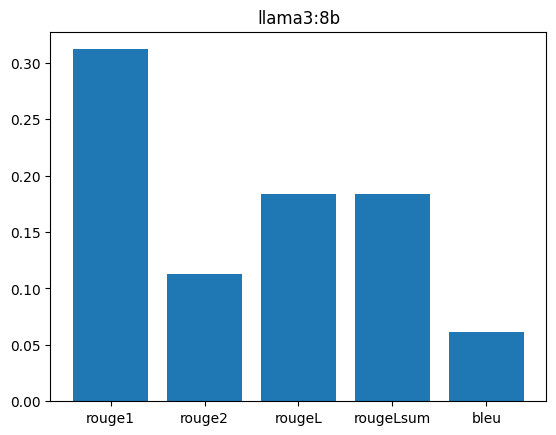

In [ ]:
import matplotlib.pyplot as plt

x = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'bleu']
y = [results_R[r] for r in x[:4]] + [results_B['bleu']]
plt.bar(x,y)
plt.title("llama3:8b")
plt.show()